<a href="https://colab.research.google.com/github/aim56009/Bias_GAN/blob/master/code/Compute_PSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [14]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
%%capture
!pip install pytorch_lightning
!pip install basemap
!pip install numpy==1.21.2 
!pip install pysteps==1.3.2
!pip install xclim
!git clone https://github.com/aim56009/Bias_GAN.git

from pysteps.utils.spectral import rapsd, corrcoef
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib.ticker as ticker
from scipy.stats import wasserstein_distance

# Version to evaluate

In [21]:
version = "2023_01_19_16h_26m_23s"

# PSD class

In [22]:
class SpatialSpectralDensity():
    
    def __init__(self):
        
        self.time_period = ('2001', '2014')
        self.num_times = None
        
        self.gan = xr.open_dataset(f'/content/gdrive/MyDrive/bias_gan/results/{version}/gan.nc').gan_precipitation
        self.era5 = xr.open_dataset(f"/content/gdrive/MyDrive/bias_gan/data_gan/pr_W5E5v2.0_regionbox_era5_1979-2014.nc").era5_precipitation#*3600*24 
        self.poem = xr.open_dataset(f"/content/gdrive/MyDrive/bias_gan/data_gan/pr_gfdl-esm4_historical_regionbox_1979-2014.nc").precipitation#*3600*24 
        
        
        
    def compute_mean_spectral_density(self, data: xr.DataArray):
        
        #data = data.sel(time=slice(self.time_period[0], self.time_period[1]))
        data = data.isel(longitude=slice(0+10,59+10), latitude=slice(0+10,59+10))
        num_frequencies = np.max((len(data.latitude.values),
                                  len(data.longitude.values)))/2
        mean_spectral_density = np.zeros(int(num_frequencies))
        if self.num_times is None:
            num_times = int(len(data.time))
            
        elif self.timestamp is not None:
            num_times = 1
            
        else:
            num_times = self.num_times
        
        for t in range(num_times):
            if self.timestamp is not None:
                tmp = data.sel(time=self.timestamp).values
            else:
                tmp = data.isel(time=t).values
            psd, freq = rapsd(tmp, return_freq=True, normalize=True, fft_method=np.fft)
            mean_spectral_density += psd
        mean_spectral_density /= num_times
        
        return mean_spectral_density, freq
    
    
    def run(self, num_times=None, timestamp=None):
        self.num_times = num_times
        self.timestamp = timestamp
        self.gan_psd, self.freq = self.compute_mean_spectral_density(self.gan)
        self.era5_psd, self.freq = self.compute_mean_spectral_density(self.era5)
        self.poem_psd, self.freq = self.compute_mean_spectral_density(self.poem)

        
        
    def plot_psd(self, axis=None, fname=None, fontsize=None, linewidth=None, model_resolution=0.25):
        if axis is None: 
            _, ax = plt.subplots(figsize=(7,6))
        else:
            ax = axis
        plt.rcParams.update({'font.size': 12})
        x_vals = 1/self.freq*model_resolution*111/2
        ax.plot(x_vals, self.era5_psd, label='ERA5', color='k', linewidth=linewidth)
        ax.plot(x_vals, self.poem_psd , label='CM2Mc-LPJmL', color='r', linewidth=linewidth)
        ax.plot(x_vals, self.gan_psd, label='GAN', color='c', linewidth=linewidth)
        ax.legend(loc='lower right', fontsize=fontsize)
        ax.set_yscale('log', basey=2)
        ax.set_xscale('log', basex=2)
        ax.tick_params(axis='x', labelsize=fontsize)
        ax.tick_params(axis='y', labelsize=fontsize)
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
        ax.grid()
        ax.set_ylim(4.5e-5, 0.07)
        ax.set_xlabel(r'k [km]', fontsize=fontsize)
        ax.set_ylabel('PSD [a.u]', fontsize=fontsize)
        ax.set_title("PSD")

        print("absolute error era5 - poem:",np.sum(abs(self.era5_psd-self.poem_psd)))
        print("absolute error era5 - gan_psd:",np.sum(abs(self.era5_psd-self.gan_psd)))      #### should we take the abs value?
        print(" should we take the abs value? np.sum(abs(self.era5_psd-self.gan_psd))")
        print("")
        w_distance_model = wasserstein_distance(self.era5_psd, self.poem_psd)
        print("Wasserstein distance climate model",w_distance_model )
        w_distance_gan = wasserstein_distance(self.era5_psd, self.gan_psd)
        print("Wasserstein distance gan",w_distance_gan )

        if fname is not None:
            plt.savefig(fname, format='pdf', bbox_inches='tight')


    def plot_log(self, axis=None, fname=None, fontsize=None, linewidth=None, model_resolution=0.25):
        
        if axis is None: 
            _, ax = plt.subplots(figsize=(7,6))
        else:
            ax = axis

        plt.rcParams.update({'font.size': 12})
        x_vals = 1/self.freq*model_resolution*111/2
        ax.plot(x_vals, np.log(self.era5_psd), label='ERA5', color='k', linewidth=linewidth)
        ax.plot(x_vals, np.log(self.poem_psd) , label='CM2Mc-LPJmL', color='r', linewidth=linewidth)
        ax.plot(x_vals, np.log(self.gan_psd), label='GAN', color='c', linewidth=linewidth)
        ax.legend(loc='lower right', fontsize=fontsize)
        ax.set_xscale('log', basex=2)
        ax.tick_params(axis='x', labelsize=fontsize)
        ax.tick_params(axis='y', labelsize=fontsize)
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
        ax.grid()
        ax.set_xlabel(r'k [km]', fontsize=fontsize)
        ax.set_ylabel('PSD [a.u]', fontsize=fontsize)
        ax.set_title("log psd error")
        print("absolute log error era5 - poem:",np.sum(abs(np.log(self.era5_psd)-np.log(self.poem_psd))))
        print("absolute log error era5 - gan_psd:",np.sum(abs(np.log(self.era5_psd)-np.log(self.gan_psd))))

        print("")
        w_distance_model = wasserstein_distance(np.log(self.era5_psd), np.log(self.poem_psd))
        print("Wasserstein distance climate model",w_distance_model )
        w_distance_gan = wasserstein_distance(np.log(self.era5_psd), np.log(self.poem_psd))
        print("Wasserstein distance gan",w_distance_gan )

        
        if fname is not None:
            plt.savefig(fname, format='pdf', bbox_inches='tight')


    def plot_abs_log_er(self, axis=None, fname=None, fontsize=None, linewidth=None, model_resolution=0.25):
        
        if axis is None: 
            _, ax = plt.subplots(figsize=(7,6))
            #fig, ax = plt.subplots(1,2,figsize=(6, 6),  constrained_layout=True)
        
        else:
            ax = axis

        plt.rcParams.update({'font.size': 12})
        x_vals = 1/self.freq*model_resolution*111/2
        ax.plot(x_vals, np.abs(np.log(self.era5_psd)-np.log(self.poem_psd)) , label='CM2Mc-LPJmL', color='r', linewidth=linewidth)
        ax.plot(x_vals, np.abs(np.log(self.era5_psd)-np.log(self.gan_psd)), label='GAN', color='c', linewidth=linewidth)
        ax.legend(loc='upper right', fontsize=fontsize)
        ax.set_xscale('log', basex=2)
        ax.tick_params(axis='x', labelsize=fontsize)
        ax.tick_params(axis='y', labelsize=fontsize)
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
        ax.grid()
        ax.set_xlabel(r'k [km]', fontsize=fontsize)
        ax.set_ylabel('PSD [a.u]', fontsize=fontsize)
        ax.set_title("absolute log psd error")
        print("log error era5 - poem:",np.sum(abs(np.log(self.era5_psd)-np.log(self.poem_psd))))
        print("log error era5 - gan_psd:",np.sum(abs(np.log(self.era5_psd)-np.log(self.gan_psd))))
        
        if fname is not None:
            plt.savefig(fname, format='pdf', bbox_inches='tight')

# RUN PSD

absolute error era5 - poem: 0.05676308146316814
absolute error era5 - gan_psd: 0.010350855090121933
 should we take the abs value? np.sum(abs(self.era5_psd-self.gan_psd))

Wasserstein distance climate model 0.001957206223200622
Wasserstein distance gan 0.0003569260375904115


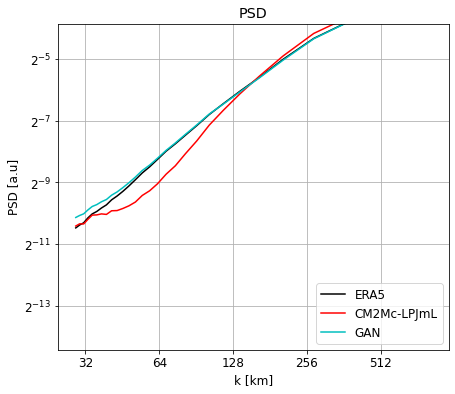

In [23]:
ssd = SpatialSpectralDensity()
ssd.run(num_times=None)

ssd.plot_psd(fname=f'/content/gdrive/MyDrive/bias_gan/results/{version}/gan_psd.pdf' )

absolute log error era5 - poem: 6.704712861525201
absolute log error era5 - gan_psd: 2.1215461973054053

Wasserstein distance climate model 0.2310128433482844
Wasserstein distance gan 0.2310128433482844


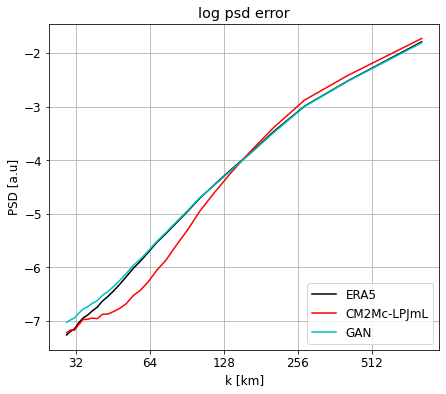

In [24]:
ssd = SpatialSpectralDensity()
ssd.run(num_times=None)

ssd.plot_log(fname=f'/content/gdrive/MyDrive/bias_gan/results/{version}/gan_log_psd.pdf')

log error era5 - poem: 6.704712861525201
log error era5 - gan_psd: 2.1215461973054053


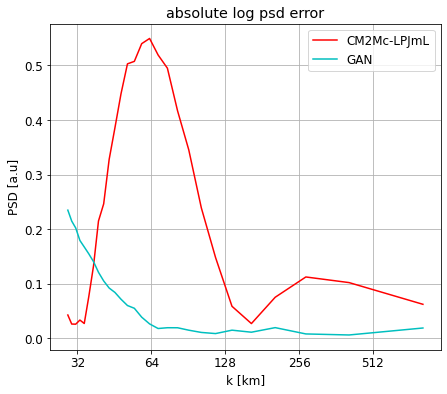

In [25]:
ssd = SpatialSpectralDensity()
ssd.run(num_times=None)

ssd.plot_abs_log_er(fname=f'/content/gdrive/MyDrive/bias_gan/results/{version}/gan_abs_log_err_psd.pdf' )

# Ideas

* the printed absolute errors might be wrong if I just np.sum over the list because pos and negatives cancel out - do abs